In [1]:
%matplotlib inline

!pip install pennylane
!pip install seaborn  # Install the Seaborn library
import seaborn as sns

import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.1 MB/s eta 0:00:00


Import Dataset

In [2]:
!wget https://www.dropbox.com/scl/fi/vksax6njscv01z4m83cdl/Deepfake_Dataset.zip?rlkey=ugsddp9hwkv8yyczzyu86dn6v&st=dpbce48y&dl=0

--2024-11-29 05:33:31--  https://www.dropbox.com/scl/fi/vksax6njscv01z4m83cdl/Deepfake_Dataset.zip?rlkey=ugsddp9hwkv8yyczzyu86dn6v
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8803ff0bb45f65343267c0b011.dl.dropboxusercontent.com/cd/0/inline/CfQPF_J4SoyX0FsBvbyCdZ2XfV-2pN0pNJ6-JLF4lV8XNsLlY9WDo41z3JaMwFaimxnZ9za-R-E5OPHNlUF6YwKFRQRzr-hyKdy1Hva6ZJ6e1tq84IGcAsk-RmFmN8unNfIPNo_UncfFAjJrpHoWx2-F/file# [following]
--2024-11-29 05:33:31--  https://uc8803ff0bb45f65343267c0b011.dl.dropboxusercontent.com/cd/0/inline/CfQPF_J4SoyX0FsBvbyCdZ2XfV-2pN0pNJ6-JLF4lV8XNsLlY9WDo41z3JaMwFaimxnZ9za-R-E5OPHNlUF6YwKFRQRzr-hyKdy1Hva6ZJ6e1tq84IGcAsk-RmFmN8unNfIPNo_UncfFAjJrpHoWx2-F/file
Resolving uc8803ff0bb45f65343267c0b011.dl.dropboxusercontent.com (uc8803ff0bb45f65343267c0b011.dl.dropboxusercontent.com)... 162.125.5

In [3]:
!unzip Deepfake_Dataset.zip?rlkey=ugsddp9hwkv8yyczzyu86dn6v

Archive:  Deepfake_Dataset.zip?rlkey=ugsddp9hwkv8yyczzyu86dn6v
   creating: Deepfake_Dataset/
   creating: Deepfake_Dataset/Test/
   creating: Deepfake_Dataset/Test/fake/
   creating: Deepfake_Dataset/Test/fake/1/
  inflating: Deepfake_Dataset/Test/fake/1/1_swapped.mp4  
  inflating: Deepfake_Dataset/Test/fake/1/frame00000.png  
  inflating: Deepfake_Dataset/Test/fake/1/frame00001.png  
  inflating: Deepfake_Dataset/Test/fake/1/frame00002.png  
  inflating: Deepfake_Dataset/Test/fake/1/frame00003.png  
  inflating: Deepfake_Dataset/Test/fake/1/frame00004.png  
  inflating: Deepfake_Dataset/Test/fake/1/frame00005.png  
  inflating: Deepfake_Dataset/Test/fake/1/frame00006.png  
  inflating: Deepfake_Dataset/Test/fake/1/frame00007.png  
  inflating: Deepfake_Dataset/Test/fake/1/frame00008.png  
  inflating: Deepfake_Dataset/Test/fake/1/frame00009.png  
  inflating: Deepfake_Dataset/Test/fake/1/frame00010.png  
  inflating: Deepfake_Dataset/Test/fake/1/frame00011.png  
  inflating: Deepfak

In [4]:
n_epochs = 200  # Number of optimization epochs
n_layers = 4   # Number of random layers

# Adjust to indicate that the entire training dataset will be used
SAVE_PATH = "/content/quanvolution/"  # Data saving folder
PREPROCESS = True          # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)          # Seed for NumPy random number generator
tf.random.set_seed(0)      # Seed for TensorFlow random number generator

# New variable to hold the validation split ratio
validation_split_ratio = 0.2  # 20% of the training data will be used for validation


Quantum Preprocessing and Save Datasets

In [5]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import pennylane as qml

# Define the number of layers and the number of wires (2 for binary classification)
n_layers = 3  # Adjust based on your needs
dev = qml.device("default.qubit", wires=2)  # Use 2 wires for 2 classes

# Random circuit parameters: Each layer will have parameters for 2 qubits
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 2, 2))  # shape (n_layers, 2, 2)

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 2 classical input values (could be features from your images)
    for j in range(2):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    for layer in range(n_layers):
        qml.templates.layers.RandomLayers(weights=rand_params[layer], wires=list(range(2)))

    # Measurement producing 2 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(2)]

def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 2))  # Output shape adjusted for 2 classes

    # Loop over the coordinates of the top-left pixel of 2x2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],      # Top-left pixel value
                    image[j, k + 1, 0]   # Top-right pixel value
                ]
            )
            # Assign expectation values to the output pixel (j/2, k/2)
            for c in range(2):  # Adjusted to 2 channels for binary classification
                out[j // 2, k // 2, c] = q_results[c]
    return out

# Define the paths to your datasets
train_data_dir = '/content/Deepfake_Dataset/Train'  # Path to training dataset
test_data_dir = '/content/Deepfake_Dataset/Test'    # Path to test dataset

# Function to load a limited number of frames (e.g., 100) from each subfolder in a specified folder
def load_train_frames(folder, num_frames):
    images = []
    labels = []
    frame_names = []  # List to store frame names
    for label in ['original', 'fake']:
        label_folder = os.path.join(folder, label)
        if not os.path.exists(label_folder):
            print(f"Directory {label_folder} does not exist.")
            continue
        for subfolder in os.listdir(label_folder):
            subfolder_path = os.path.join(label_folder, subfolder)
            if not os.path.isdir(subfolder_path):
                continue
            # Load a limited number of frames per subfolder
            count = 0
            for img_filename in os.listdir(subfolder_path):
                if img_filename.endswith('.png') and count < num_frames:
                    img_path = os.path.join(subfolder_path, img_filename)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
                    if img is not None:
                        img = cv2.resize(img, (28, 28))  # Resize to 28x28
                        images.append(img)
                        labels.append(0 if label == 'original' else 1)  # Standard labeling
                        frame_names.append(f"{label}/{subfolder}/{img_filename}")  # Store the frame name
                        count += 1
    print(f"Loaded {len(images)} images from the training dataset.")
    return np.array(images), np.array(labels), frame_names  # Return frame names as well

# Load 100 frames from each subfolder in the training dataset
train_images, train_labels, train_frame_names = load_train_frames(train_data_dir, num_frames=30)  # Adjust the number of frames here

# Check if images were loaded
if len(train_images) == 0:
    raise ValueError("No images were loaded. Please check the dataset directory.")

# Split 20% of the training dataset for validation (80% train, 20% validation)
train_images, val_images, train_labels, val_labels, train_frame_names, val_frame_names = train_test_split(
    train_images, train_labels, train_frame_names, test_size=0.20, random_state=42, stratify=train_labels
)

# Normalize pixel values within 0 and 1
train_images = train_images / 255.0
val_images = val_images / 255.0

# Add extra dimension for convolution channels
train_images = np.expand_dims(train_images, axis=-1)  # Add channel dimension
val_images = np.expand_dims(val_images, axis=-1)      # Add channel dimension

# Load 100 frames from each subfolder in the testing dataset (only 'fake' images)
def load_test_frames(folder, num_frames):
    images = []
    frame_names = []  # List to store frame names
    for subfolder in range(1, 11):  # Subfolders 1 to 10
        subfolder_path = os.path.join(folder, 'fake', str(subfolder))  # Use 'fake' folder
        if not os.path.isdir(subfolder_path):
            continue
        count = 0
        for img_filename in os.listdir(subfolder_path):
            if img_filename.endswith('.png') and count < num_frames:
                img_path = os.path.join(subfolder_path, img_filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
                if img is not None:
                    img = cv2.resize(img, (28, 28))  # Resize to 28x28
                    images.append(img)
                    frame_names.append(f"fake/{subfolder}/{img_filename}")  # Store the frame name
                    count += 1
    print(f"Loaded {len(images)} images from the test dataset.")
    return np.array(images), frame_names  # Return frame names as well

# Load 100 frames from each subfolder in the testing dataset
test_images, test_frame_names = load_test_frames(test_data_dir, num_frames=30)  # Adjust the number of frames here
test_labels = np.ones(len(test_images))  # All test images are labeled as 'fake' (1)

# Normalize pixel values within 0 and 1 for test images
test_images = test_images / 255.0

# Add extra dimension for convolution channels for test images
test_images = np.expand_dims(test_images, axis=-1)  # Add channel dimension

# Preprocess the images using the quantum circuit for training, validation, and test data
SAVE_PATH = "/content/quanvolution/"

# Create the directory if it doesn't exist
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

q_train_images = []
print("Quantum pre-processing of train images:")
for idx, img in enumerate(train_images):
    print("{}/{}        ".format(idx + 1, len(train_images)), end="\r")
    q_train_images.append(quanv(img))
q_train_images = np.asarray(q_train_images)

q_val_images = []
print("\nQuantum pre-processing of validation images:")
for idx, img in enumerate(val_images):
    print("{}/{}        ".format(idx + 1, len(val_images)), end="\r")
    q_val_images.append(quanv(img))
q_val_images = np.asarray(q_val_images)

# Preprocess the test images using the quantum circuit
q_test_images = []
print("\nQuantum pre-processing of test images:")
for idx, img in enumerate(test_images):
    print("{}/{}        ".format(idx + 1, len(test_images)), end="\r")
    q_test_images.append(quanv(img))
q_test_images = np.asarray(q_test_images)

# Save pre-processed images in .npy format
np.save(os.path.join(SAVE_PATH, "q_train_images.npy"), q_train_images)
np.save(os.path.join(SAVE_PATH, "q_val_images.npy"), q_val_images)
np.save(os.path.join(SAVE_PATH, "q_test_images.npy"), q_test_images)

# Save frame names to CSV files
train_frame_df = pd.DataFrame({'frame_name': train_frame_names, 'label': train_labels})
val_frame_df = pd.DataFrame({'frame_name': val_frame_names, 'label': val_labels})
test_frame_df = pd.DataFrame({'frame_name': test_frame_names, 'label': test_labels})

train_frame_df.to_csv(os.path.join(SAVE_PATH, "train_frame_names.csv"), index=False)
val_frame_df.to_csv(os.path.join(SAVE_PATH, "val_frame_names.csv"), index=False)
test_frame_df.to_csv(os.path.join(SAVE_PATH, "test_frame_names.csv"), index=False)

# Optional: Print shapes to verify
print(f'Train images shape: {q_train_images.shape}, Train labels shape: {train_labels.shape}')
print(f'Validation images shape: {q_val_images.shape}, Validation labels shape: {val_labels.shape}')
print(f'Test images shape: {q_test_images.shape}, Test labels shape: {test_labels.shape}')


Loaded 596 images from the training dataset.
Loaded 300 images from the test dataset.
Quantum pre-processing of train images:

Quantum pre-processing of validation images:

Quantum pre-processing of test images:
Train images shape: (476, 14, 14, 2), Train labels shape: (476,)
Validation images shape: (120, 14, 14, 2), Validation labels shape: (120,)
Test images shape: (300, 14, 14, 2), Test labels shape: (300,)


whole dataset

In [6]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import pennylane as qml

# Define the number of layers and the number of wires (2 for binary classification)
n_layers = 3  # Adjust based on your needs
dev = qml.device("default.qubit", wires=2)  # Use 2 wires for 2 classes

# Random circuit parameters: Each layer will have parameters for 2 qubits
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 2, 2))  # shape (n_layers, 2, 2)

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 2 classical input values (could be features from your images)
    for j in range(2):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    for layer in range(n_layers):
        qml.templates.layers.RandomLayers(weights=rand_params[layer], wires=list(range(2)))

    # Measurement producing 2 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(2)]

def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 2))  # Output shape adjusted for 2 classes

    # Loop over the coordinates of the top-left pixel of 2x2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],      # Top-left pixel value
                    image[j, k + 1, 0]   # Top-right pixel value
                ]
            )
            # Assign expectation values to the output pixel (j/2, k/2)
            for c in range(2):  # Adjusted to 2 channels for binary classification
                out[j // 2, k // 2, c] = q_results[c]
    return out

# Define the paths to your datasets
train_data_dir = '/content/Deepfake_Dataset/Train'  # Path to training dataset
test_data_dir = '/content/Deepfake_Dataset/Test'    # Path to test dataset

# Function to load all frames from each subfolder in a specified folder
def load_train_frames(folder):
    images = []
    labels = []
    frame_names = []  # List to store frame names
    for label in ['original', 'fake']:
        label_folder = os.path.join(folder, label)
        if not os.path.exists(label_folder):
            print(f"Directory {label_folder} does not exist.")
            continue
        for subfolder in os.listdir(label_folder):
            subfolder_path = os.path.join(label_folder, subfolder)
            if not os.path.isdir(subfolder_path):
                continue
            # Load all frames per subfolder
            for img_filename in os.listdir(subfolder_path):
                if img_filename.endswith('.png'):
                    img_path = os.path.join(subfolder_path, img_filename)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
                    if img is not None:
                        img = cv2.resize(img, (28, 28))  # Resize to 28x28
                        images.append(img)
                        labels.append(0 if label == 'original' else 1)  # Standard labeling
                        frame_names.append(f"{label}/{subfolder}/{img_filename}")  # Store the frame name
    print(f"Loaded {len(images)} images from the training dataset.")
    return np.array(images), np.array(labels), frame_names  # Return frame names as well

# Load all frames from each subfolder in the training dataset
train_images, train_labels, train_frame_names = load_train_frames(train_data_dir)

# Check if images were loaded
if len(train_images) == 0:
    raise ValueError("No images were loaded. Please check the dataset directory.")

# Split 20% of the training dataset for validation (80% train, 20% validation)
train_images, val_images, train_labels, val_labels, train_frame_names, val_frame_names = train_test_split(
    train_images, train_labels, train_frame_names, test_size=0.20, random_state=42, stratify=train_labels
)

# Normalize pixel values within 0 and 1
train_images = train_images / 255.0
val_images = val_images / 255.0

# Add extra dimension for convolution channels
train_images = np.expand_dims(train_images, axis=-1)  # Add channel dimension
val_images = np.expand_dims(val_images, axis=-1)      # Add channel dimension

# Load all frames from each subfolder in the testing dataset (only 'fake' images)
def load_test_frames(folder):
    images = []
    frame_names = []  # List to store frame names
    for subfolder in range(1, 11):  # Subfolders 1 to 10
        subfolder_path = os.path.join(folder, 'fake', str(subfolder))  # Use 'fake' folder
        if not os.path.isdir(subfolder_path):
            continue
        for img_filename in os.listdir(subfolder_path):
            if img_filename.endswith('.png'):
                img_path = os.path.join(subfolder_path, img_filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
                if img is not None:
                    img = cv2.resize(img, (28, 28))  # Resize to 28x28
                    images.append(img)
                    frame_names.append(f"fake/{subfolder}/{img_filename}")  # Store the frame name
    print(f"Loaded {len(images)} images from the test dataset.")
    return np.array(images), frame_names  # Return frame names as well

# Load all frames from each subfolder in the testing dataset
test_images, test_frame_names = load_test_frames(test_data_dir)
test_labels = np.ones(len(test_images))  # All test images are labeled as 'fake' (1)

# Normalize pixel values within 0 and 1 for test images
test_images = test_images / 255.0

# Add extra dimension for convolution channels for test images
test_images = np.expand_dims(test_images, axis=-1)  # Add channel dimension

# Preprocess the images using the quantum circuit for training, validation, and test data
SAVE_PATH = "/content/quanvolution/"

# Create the directory if it doesn't exist
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

q_train_images = []
print("Quantum pre-processing of train images:")
for idx, img in enumerate(train_images):
    print("{}/{}        ".format(idx + 1, len(train_images)), end="\r")
    q_train_images.append(quanv(img))
q_train_images = np.asarray(q_train_images)

q_val_images = []
print("\nQuantum pre-processing of validation images:")
for idx, img in enumerate(val_images):
    print("{}/{}        ".format(idx + 1, len(val_images)), end="\r")
    q_val_images.append(quanv(img))
q_val_images = np.asarray(q_val_images)

# Preprocess the test images using the quantum circuit
q_test_images = []
print("\nQuantum pre-processing of test images:")
for idx, img in enumerate(test_images):
    print("{}/{}        ".format(idx + 1, len(test_images)), end="\r")
    q_test_images.append(quanv(img))
q_test_images = np.asarray(q_test_images)

# Save pre-processed images in .npy format
np.save(os.path.join(SAVE_PATH, "q_train_images.npy"), q_train_images)
np.save(os.path.join(SAVE_PATH, "q_val_images.npy"), q_val_images)
np.save(os.path.join(SAVE_PATH, "q_test_images.npy"), q_test_images)

# Save frame names to CSV files
train_frame_df = pd.DataFrame({'frame_name': train_frame_names, 'label': train_labels})
val_frame_df = pd.DataFrame({'frame_name': val_frame_names, 'label': val_labels})
test_frame_df = pd.DataFrame({'frame_name': test_frame_names, 'label': test_labels})

train_frame_df.to_csv(os.path.join(SAVE_PATH, "train_frame_names.csv"), index=False)
val_frame_df.to_csv(os.path.join(SAVE_PATH, "val_frame_names.csv"), index=False)
test_frame_df.to_csv(os.path.join(SAVE_PATH, "test_frame_names.csv"), index=False)

# Optional: Print shapes to verify
print(f'Train images shape: {q_train_images.shape}, Train labels shape: {train_labels.shape}')
print(f'Validation images shape: {q_val_images.shape}, Validation labels shape: {val_labels.shape}')
print(f'Test images shape: {q_test_images.shape}, Test labels shape: {test_labels.shape}')


Loaded 1946 images from the training dataset.
Loaded 1061 images from the test dataset.
Quantum pre-processing of train images:

Quantum pre-processing of validation images:

Quantum pre-processing of test images:
Train images shape: (1556, 14, 14, 2), Train labels shape: (1556,)
Validation images shape: (390, 14, 14, 2), Validation labels shape: (390,)
Test images shape: (1061, 14, 14, 2), Test labels shape: (1061,)


Visualize Input and Output Images

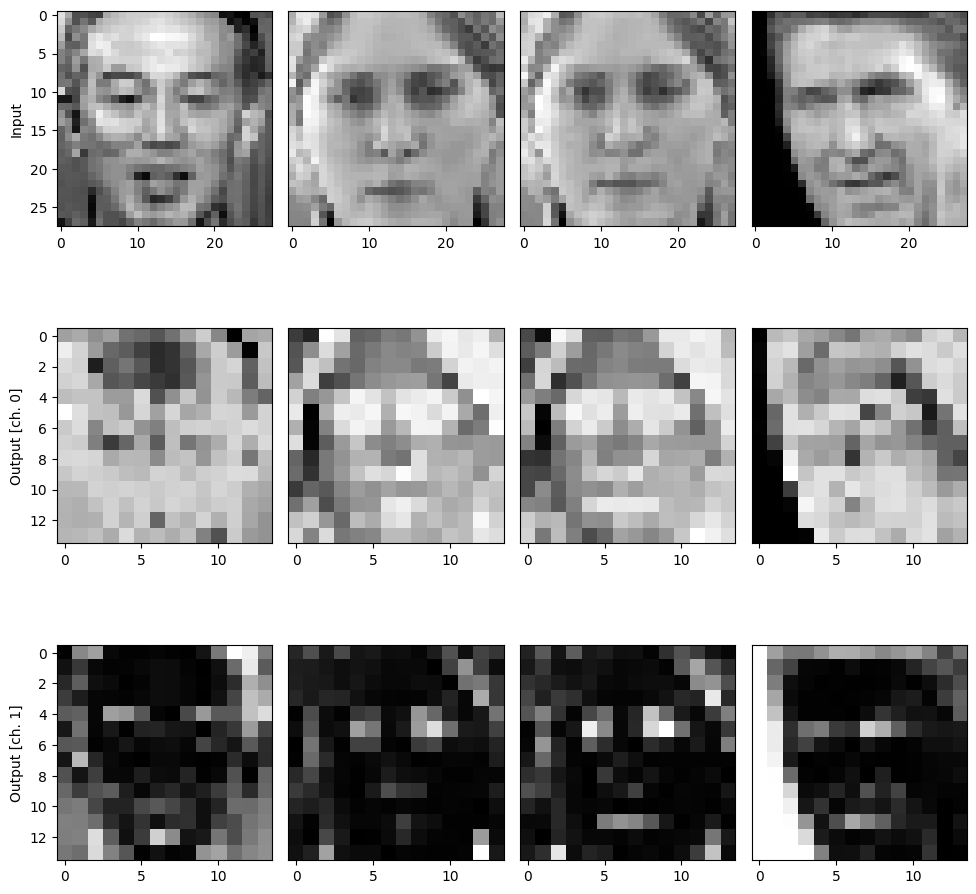

In [7]:
import matplotlib.pyplot as plt

# Number of samples to visualize
n_samples = 4
n_channels = 2  # 2 for binary classification

# Create subplots: 1 row for input images, and n_channels rows for output channels
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))

# Ensure axes is always a 2D array
if n_samples == 1:
    axes = np.expand_dims(axes, axis=1)
if n_channels == 1:
    axes = np.expand_dims(axes, axis=0)

# Randomly select indices from the training data
random_indices = np.random.choice(train_images.shape[0], size=n_samples, replace=False)

for k, idx in enumerate(random_indices):
    # Display the input image
    axes[0, k].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[idx, :, :, 0], cmap="gray")  # Input images

    # Plot all output channels for quantum processed images
    for c in range(n_channels):
        axes[c + 1, k].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c + 1, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[idx, :, :, c], cmap="gray")  # Output images

plt.tight_layout()
plt.show()


CNN model

In [8]:
def MyModel():
    """Initializes and returns a custom Keras model for classical images."""
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28, 28, 1)),  # Input shape for 28x28 grayscale images
        keras.layers.Dense(64, activation="relu"),      # Hidden layer with more neurons
        keras.layers.Dense(1, activation="sigmoid")     # Output layer for binary classification
    ])

    model.compile(
        optimizer='adam',
        loss="binary_crossentropy",  # Binary cross-entropy for binary classification
        metrics=["accuracy"],
    )
    return model


modified

In [9]:
def MyModel():
    """Initializes and returns a custom Keras model for classical images."""
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28, 28, 1)),  # Input shape for 28x28 grayscale images
        keras.layers.Dense(64, activation="relu", input_shape=(784,)),      # Hidden layer with more neurons, explicitly define input_shape
        keras.layers.Dense(1, activation="sigmoid")     # Output layer for binary classification
    ])

    model.compile(
        optimizer='adam',
        loss="binary_crossentropy",  # Binary cross-entropy for binary classification
        metrics=["accuracy"],
    )
    return model

Train CNN

In [10]:
!pip install seaborn  # Install the Seaborn library
import seaborn as sns
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tensorflow import keras

# Ensure train_labels and test_labels are in binary format (0 for fake, 1 for original)
# Assuming you already have train_labels and test_labels prepared correctly

# Initialize the classical model
c_model = MyModel()

# Fit the classical model to the training data
c_history = c_model.fit(
    train_images,               # Your preprocessed training images
    train_labels,               # Your binary labels for training
    validation_data=(val_images, val_labels),  # Use validation data
    batch_size=4,               # You can adjust this if needed
    epochs=n_epochs,            # Ensure n_epochs is defined
    verbose=2,                  # Output verbosity
)

# Save the training history as Excel
c_history_df = pd.DataFrame(c_history.history)
c_history_df.to_excel('/content/noq_c_model_history.xlsx', index=False)

# Save the history object with pickle
with open('/content/noq_c_model_history.pkl', 'wb') as f:
    pickle.dump(c_history.history, f)

# Load the saved history from Excel (if needed)
loaded_c_history_df = pd.read_excel('/content/noq_c_model_history.xlsx')

# Load the saved history object from pickle (if needed)
with open('/content/noq_c_model_history.pkl', 'rb') as f:
    loaded_c_history = pickle.load(f)




/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
389/389 - 3s - 8ms/step - accuracy: 0.5495 - loss: 0.7062 - val_accuracy: 0.5462 - val_loss: 0.6549
Epoch 2/200
389/389 - 1s - 1ms/step - accuracy: 0.6536 - loss: 0.6245 - val_accuracy: 0.5821 - val_loss: 0.6030
Epoch 3/200
389/389 - 1s - 1ms/step - accuracy: 0.7281 - loss: 0.5568 - val_accuracy: 0.6000 - val_loss: 0.5704
Epoch 4/200
389/389 - 1s - 2ms/step - accuracy: 0.7834 - loss: 0.4797 - val_accuracy: 0.8615 - val_loss: 0.4124
Epoch 5/200
389/389 - 1s - 1ms/step - accuracy: 0.8406 - loss: 0.4008 - val_accuracy: 0.8590 - val_loss: 0.3491
Epoch 6/200
389/389 - 1s - 2ms/step - accuracy: 0.8689 - loss: 0.3329 - val_accuracy: 0.8128 - val_loss: 0.3586
Epoch 7/200
389/389 - 1s - 1ms/step - accuracy: 0.8997 - loss: 0.2778 - val_accuracy: 0.7846 - val_loss: 0.3922
Epoch 8/200
389/389 - 1s - 1ms/step - accuracy: 0.9158 - loss: 0.2358 - val_accuracy: 0.7949 - val_loss: 0.3846
Epoch 9/200
389/389 - 1s - 2ms/step - accuracy: 0.9261 - loss: 0.2027 - val_accuracy: 0.8026 - val_loss:

Test CNN

In [13]:
# Predict the output for the test data using the trained classical model
c_test_predictions = c_model.predict(test_images)  # Predict probabilities for test images

# Convert probabilities to binary predictions (0 or 1) based on a threshold of 0.5
c_test_pred_labels = (c_test_predictions > 0.5).astype(int)  # Convert probabilities to 0 or 1

# Load frame names from the CSV file for the test data
test_frame_names_df = pd.read_csv('/content/quanvolution/test_frame_names.csv')
test_frame_names = test_frame_names_df['frame_name'].values

# Calculate the test accuracy by comparing predictions with true labels
test_accuracy = np.mean(c_test_pred_labels.flatten() == test_labels)  # Flatten to ensure shapes match

# Calculate the test loss using the evaluate method
c_test_loss, _ = c_model.evaluate(test_images, test_labels, verbose=0)  # We ignore accuracy here

# Print the test accuracy and loss
print(f"Classical Model Test Loss: {c_test_loss:.4f}")
print(f"Classical Model Test Accuracy: {test_accuracy * 100:.2f}%")

# Create a DataFrame to save predictions along with frame names
predictions_df = pd.DataFrame({
    'Frame Name': test_frame_names,  # Using the correct frame name
    'True Label': test_labels,
    'Predicted Label': c_test_pred_labels.flatten()
})

# Save predictions to Excel
excel_path = '/content/noq_c_model_test_predictions.xlsx'
predictions_df.to_excel(excel_path, index=False)

# Download the generated Excel file
#from google.colab import files
#files.download(excel_path)  # This will trigger the download of the Excel file

# Optionally, save the predictions with pickle
with open('/content/noq_c_model_test_predictions.pkl', 'wb') as f:
    pickle.dump(c_test_pred_labels, f)

print("noq_c_model_test_predictions.xlsx Saved and downloaded successfully")


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Classical Model Test Loss: 3.3358
Classical Model Test Accuracy: 36.76%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

noq_c_model_test_predictions.xlsx Saved and downloaded successfully


QCNN

In [14]:
from tensorflow import keras

def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Input(shape=(14, 14, 2)),  # Input shape matches the output of quanv
        keras.layers.Flatten(),                  # Flatten the input from (14, 14, 2) to (392,)
        keras.layers.Dense(16, activation="relu"),  # Hidden layer
        # Optional: Add more hidden layers if needed
        # keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid")  # Output layer for binary classification
    ])

    model.compile(
        optimizer='adam',
        loss="binary_crossentropy",  # Use binary cross-entropy for binary classification
        metrics=["accuracy"],
    )
    return model


Train QCNN

In [15]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tensorflow import keras

# Ensure train_labels and test_labels are in binary format (0 for fake, 1 for original)
# Assuming you already have train_labels and test_labels prepared correctly.

# Initialize the model using the previously defined MyModel function
q_model = MyModel()

# Fit the model to the training data, using validation data for evaluation
q_history = q_model.fit(
    q_train_images,          # Quantum pre-processed training images
    train_labels,            # Binary labels for training (0 for fake, 1 for original)
    validation_data=(q_val_images, val_labels),  # Quantum pre-processed validation images and labels
    batch_size=4,            # Batch size; can be adjusted as needed
    epochs=n_epochs,         # Number of epochs; ensure n_epochs is defined in your code
    verbose=2,               # Set to 1 for progress bar, or 0 for silent mode
)

# Save the training history as an Excel file for record-keeping
history_df = pd.DataFrame(q_history.history)
history_df.to_excel('/content/q_model_history.xlsx', index=False)

# Save the training history object with pickle for further analysis or re-use
with open('/content/q_model_history.pkl', 'wb') as f:
    pickle.dump(q_history.history, f)

# Load the saved history from Excel (if needed)
loaded_history_df = pd.read_excel('/content/q_model_history.xlsx')

# Load the saved history object from pickle (if needed)
with open('/content/q_model_history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)



Epoch 1/200
389/389 - 3s - 7ms/step - accuracy: 0.6041 - loss: 0.6641 - val_accuracy: 0.7487 - val_loss: 0.6130
Epoch 2/200
389/389 - 1s - 2ms/step - accuracy: 0.7024 - loss: 0.5864 - val_accuracy: 0.8897 - val_loss: 0.5221
Epoch 3/200
389/389 - 1s - 2ms/step - accuracy: 0.8175 - loss: 0.4845 - val_accuracy: 0.9359 - val_loss: 0.4149
Epoch 4/200
389/389 - 1s - 2ms/step - accuracy: 0.9030 - loss: 0.3783 - val_accuracy: 0.9128 - val_loss: 0.3331
Epoch 5/200
389/389 - 1s - 2ms/step - accuracy: 0.9460 - loss: 0.2845 - val_accuracy: 0.9359 - val_loss: 0.2604
Epoch 6/200
389/389 - 1s - 1ms/step - accuracy: 0.9679 - loss: 0.2139 - val_accuracy: 0.9385 - val_loss: 0.2176
Epoch 7/200
389/389 - 1s - 2ms/step - accuracy: 0.9775 - loss: 0.1641 - val_accuracy: 0.9462 - val_loss: 0.1820
Epoch 8/200
389/389 - 1s - 2ms/step - accuracy: 0.9852 - loss: 0.1292 - val_accuracy: 0.9513 - val_loss: 0.1544
Epoch 9/200
389/389 - 1s - 2ms/step - accuracy: 0.9904 - loss: 0.1038 - val_accuracy: 0.9538 - val_loss:

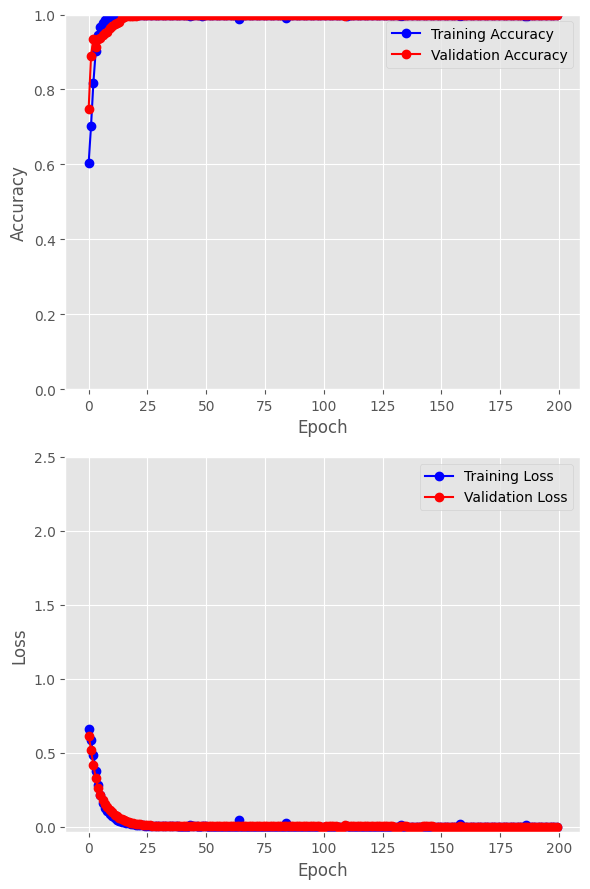

In [16]:
# Example of plotting the loaded history for visualization
import matplotlib.pyplot as plt

plt.style.use("ggplot")  # Using ggplot style instead of seaborn
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

# Plot training and validation accuracy over epochs
ax1.plot(loaded_history['accuracy'], "-ob", label="Training Accuracy")
ax1.plot(loaded_history['val_accuracy'], "-or", label="Validation Accuracy")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

# Plot training and validation loss over epochs
ax2.plot(loaded_history['loss'], "-ob", label="Training Loss")
ax2.plot(loaded_history['val_loss'], "-or", label="Validation Loss")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()

plt.tight_layout()
plt.show()


Test QCNN

In [18]:
# Predict the output for the test data using the trained QCNN model
q_test_predictions = q_model.predict(q_test_images)  # Predict probabilities for test images

# Convert probabilities to binary predictions (0 or 1) based on a threshold of 0.5
q_test_pred_labels = (q_test_predictions > 0.5).astype(int) # Convert probabilities to 0 or 1

# Load frame names from the CSV file for the test data
test_frame_names_df = pd.read_csv('/content/quanvolution/test_frame_names.csv')
test_frame_names = test_frame_names_df['frame_name'].values

# Calculate the test accuracy by comparing predictions with true labels
test_accuracy = np.mean(q_test_pred_labels.flatten() == test_labels)  # Flatten to ensure shapes match

# Calculate the test loss using the evaluate method
q_test_loss, _ = q_model.evaluate(q_test_images, test_labels, verbose=0)  # We ignore accuracy here

# Print the test accuracy and loss
print(f"QCNN Model Test Loss: {q_test_loss:.4f}")
print(f"QCNN Model Test Accuracy: {test_accuracy * 100:.2f}%")

# Create a DataFrame to save predictions along with frame names
predictions_df = pd.DataFrame({
    'Frame Name': test_frame_names,  # Using the correct frame name
    'True Label': test_labels,
    'Predicted Label': q_test_pred_labels.flatten()
})

# Save predictions to Excel
excel_path = '/content/noq_q_model_test_predictions.xlsx'
predictions_df.to_excel(excel_path, index=False)

# Download the generated Excel file
#from google.colab import files
#files.download(excel_path)  # This will trigger the download of the Excel file

# Optionally, save the predictions with pickle
with open('/content/noq_q_model_test_predictions.pkl', 'wb') as f:
    pickle.dump(q_test_pred_labels, f)

print("noq_q_model_test_predictions.xlsx Saved and downloaded successfully")


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
QCNN Model Test Loss: 2.1978
QCNN Model Test Accuracy: 65.32%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

noq_q_model_test_predictions.xlsx Saved and downloaded successfully
